<a href="https://colab.research.google.com/github/sam2005-max/CartPole-/blob/main/CartPole_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tflearn
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=084d8ed85a2bec127df03c50d852583bc6bc0e337a6b01a1b9feecb4a0acdf41
  Stored in directory: /root/.cache/pip/wheels/65/9b/15/cb1e6b279c14ed897530d15cfd7da8e3df8a947e593f5cfe59
Successfully built tflearn


In [ ]:
import gym
import time
import tensorflow as tf
import tflearn
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
import torch
import torchvision
from IPython.display import clear_output
from IPython.display import display
from sys import exit
import pygame
from pygame.locals import *
%matplotlib inline


In [ ]:
env = gym.make("CartPole-v0")

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
observation = tflearn.input_data(shape=[None, 4])
net = tflearn.fully_connected(observation, 256, activation="relu")
net = tflearn.fully_connected(net, 256, activation="relu")
net = tflearn.fully_connected(net, 256, activation="relu")
out = tflearn.fully_connected(net, 2, activation="softmax")

reward_holder = tf.placeholder(tf.float32, [None])
action_holder = tf.placeholder(tf.int32, [None])

responsible_outputs = tf.gather(tf.reshape(out, [-1]), tf.range(0, tf.shape(out)[0] * tf.shape(out)[1], 2) + action_holder)

loss = -tf.reduce_mean(tf.log(responsible_outputs) * reward_holder)

optimizer = tf.train.AdamOptimizer()
update = optimizer.minimize(loss)

In [ ]:
gamma = 0.99

def discount_reward(rewards):
    running_reward = 0
    result = np.zeros_like(rewards)
    for i in reversed(range(len(rewards))):
        result[i] = rewards[i] + gamma * running_reward
        running_reward += rewards[i]
    return result


In [ ]:
num_episodes = 1500
max_time = 200
all_rewards = []
saver = tf.train.Saver()
train_data = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_episodes):
        obs = env.reset()
        episode_reward = 0
        ep_history = []
        for j in range(max_time):
            #Choose an action
            a_one_hot = sess.run(out, feed_dict={observation: [obs]}).reshape(2)
            action = np.random.choice(a_one_hot, p=a_one_hot)
            action = np.argmax(a_one_hot == action)
            obs1, r, d, _ = env.step(action)
            ep_history.append([obs, r, action])
            obs = obs1
            episode_reward += r
            if d == True:
                all_rewards.append(episode_reward)
                ep_history = np.array(ep_history)
                ep_history[:, 1] = discount_reward(ep_history[:, 1])
                train_data.extend(ep_history)
                if i % 10 == 0 and i != 0:
                    train_data = np.array(train_data)
                    sess.run(update, feed_dict={observation: np.vstack(train_data[:, 0]),
                                                    reward_holder: train_data[:, 1],
                                                    action_holder: train_data[:, 2]})
                    train_data = []
                break
                
        if i % 100 == 0 and i != 0:
            print(np.mean(all_rewards[-100:]))
            if np.mean(all_rewards[-100:]) == 200:
                break
            
    saver.save(sess, "/tmp/model.ckpt")

<ipython-input-84-62751061a831>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_history = np.array(ep_history)


22.41
26.17
49.91
79.11
119.59
136.18
184.15


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


200.0


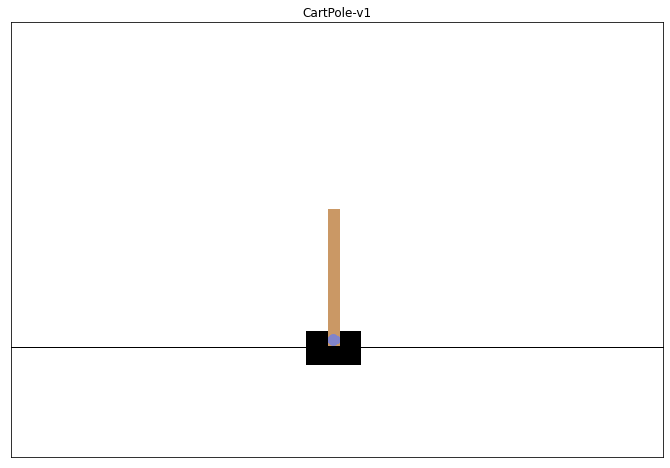

In [ ]:
# Demonstration
env = gym.envs.make("CartPole-v1")
def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)
num_steps = 2
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v1')
    plt.xticks([])
    plt.yticks([])
    plt.rcParams["figure.figsize"] = (27,8)
    # plt.figure(figsize(10,5))
    plt.show()


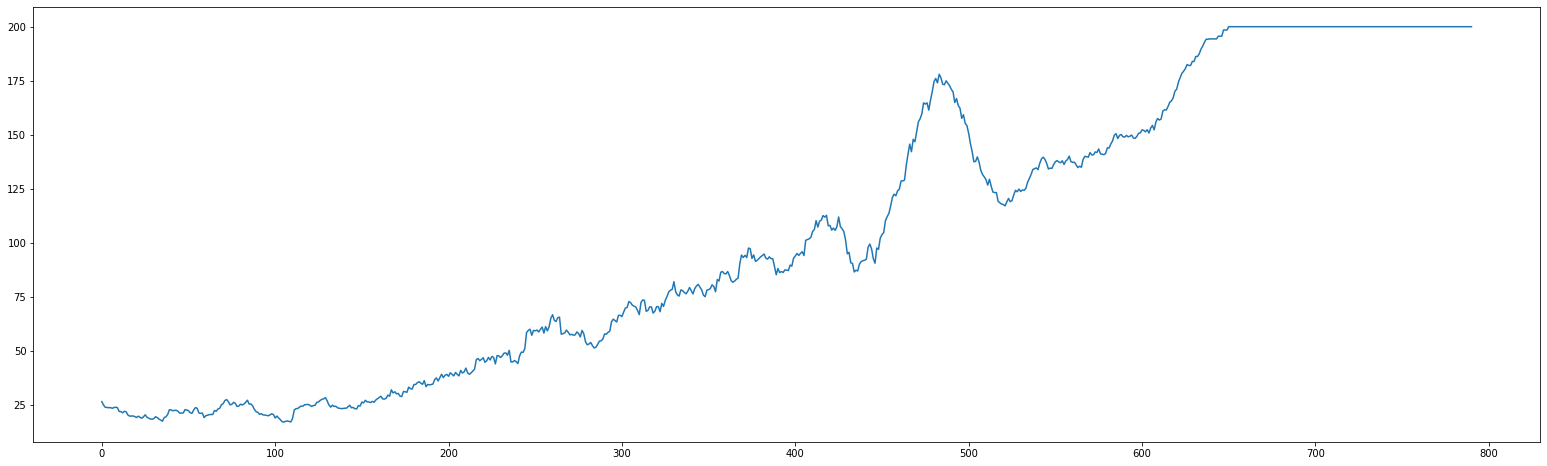

In [ ]:
avg_reward = [np.mean(all_rewards[i-10:i+10]) for i in range(10, len(all_rewards))]
var = avg_reward[::1]
# plt.plot(ypoints, linestyle = 'dotted')
plt.plot(var)
plt.rcParams["figure.figsize"] = (27,8)
plt.show()

In [ ]:
max_time = 200
saver = tf.train.Saver()
    
with tf.Session() as sess:
    saver.restore(sess, "/tmp/model.ckpt")
    #Show the results
    for i in range(10):
        obs = env.reset()
        episode_reward = 0
        for j in range(max_time):
            #Choose an action
            a_one_hot = sess.run(out, feed_dict={observation: [obs]}).reshape(2)
            action = np.random.choice(a_one_hot, p=a_one_hot)
            action = np.argmax(a_one_hot == action)
            # env.render()
            time.sleep(0.005)
            obs, r, d, _ = env.step(action)
            episode_reward += r
            if d == True:
                break
        print(episode_reward)

200.0
188.0
200.0
200.0
200.0
200.0
200.0
200.0
200.0
197.0
